In [39]:
# Setup
# This section contains all codes and presets to setup the notebook.
# Reload all modules at every code execution
%load_ext autoreload
%autoreload 2

# Dataloader
from thenetflixstory.data_processing import load_netflixdata
df_netflix = load_netflixdata()

# Default Format presets
BAR_FORMATS = {'highlight':{'color':'red'},
          'deemphasize':{'color':'lightgrey'}
          }

PLOT_FORMATS = {'figsize':()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Dataloader

import pandas as pd

# 📥 Load Netflix dataset
df = pd.read_csv("../data/netflix1.csv")

# 🧹 Filter: Valid year and rating
df = df[df['release_year'].notna() & df['rating'].notna()]
df['release_year'] = df['release_year'].astype(int)
df = df[df['release_year'] >= 2010]

# 🧠 Normalize ratings
df['rating'] = df['rating'].str.strip().str.upper()

# 🎯 Map to simplified age categories
rating_map = {
    'TV-G': 'All Ages', 'G': 'All Ages',
    'TV-Y': 'All Ages', 'TV-Y7': 'All Ages',
    'PG': '6+', 'TV-PG': '6+',
    'PG-13': '12+', 'TV-14': '12+',
    'R': '16+', 'NC-17': '16+',
    'TV-MA': '18+'
}
df['age_rating'] = df['rating'].map(rating_map)
df = df[df['age_rating'].notna()]

# 🔢 Numeric age for filtering
age_label_to_number = {
    'All Ages': 0,
    '6+': 6,
    '12+': 12,
    '16+': 16,
    '18+': 18
}
df['rating_age'] = df['age_rating'].map(age_label_to_number)

# 🎭 Genres
df['genres_list'] = df['listed_in'].str.split(',').apply(lambda lst: [g.strip() for g in lst])
df['main_genre'] = df['genres_list'].apply(lambda g: g[0] if isinstance(g, list) and g else None)
df = df[df['main_genre'].notna()]

# 🌍 Country cleanup (no explode!)
df['country_list'] = df['country'].dropna().apply(lambda x: [c.strip() for c in x.split(',')])
df['country_clean'] = df['country_list'].apply(lambda lst: lst[0] if lst else None)
df = df[df['country_clean'].notna()]

# ✅ Robust US flag (includes co-productions)
df['is_us'] = df['country_list'].apply(lambda lst: 'United States' in lst if isinstance(lst, list) else False)

# 🔧 Country corrections
pre_mapping = {
    "Soviet Union": "Russia",
    "West Germany": "Germany",
    "Not Given": None
}
df['country_clean'] = df['country_clean'].replace(pre_mapping)

# 📌 Optional reset
df = df.reset_index(drop=True)

In [14]:
#unified Design loader

# 📦 Unified Design Setup for Netflix Charts

import matplotlib.pyplot as plt
import seaborn as sns

# 🔴 Netflix-themed palette (CVD-friendly shades of red)
age_order = ['All Ages', '6+', '12+', '16+', '18+']
age_colors = {
    'All Ages': '#f6b5b5',
    '6+': '#f47b7b',
    '12+': '#e50914',   # Netflix red
    '16+': '#c40000',
    '18+': '#820000'
}

# 🔧 General matplotlib + seaborn style settings
sns.set_style("darkgrid")

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "axes.titleweight": "bold",
    "axes.labelcolor": "#111111",
    "xtick.color": "#111111",
    "ytick.color": "#111111",
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Arial"],
    "axes.edgecolor": "#333333",
    "grid.color": "#dddddd",
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "legend.frameon": False,
    "legend.title_fontsize": 11,
})

# 🎨 Shortcut for consistent age-rating color order
def get_age_colors():
    return [age_colors[age] for age in age_order]

<p align="center">
  <img src="pics/netflix_intro_logo.avif" width="800">
  <br>
  <em>Image: From Thibault Penin on https://unsplash.com/</em>
</p>

# Netflix Unfiltered - What Content Ratings and Genres Reveal About the Platform's Evolution

## Intro - Our Research Question
How has Netflix’s content strategy evolved in terms of age ratings, genres, and regional production — and what does this reveal about its shift from family entertainment to mature, globally diversified programming?

Lead

Over the past decade, Netflix has transformed from a distributor of family-oriented content into one of the world’s most influential producers of mature, globally-targeted programming. But what does that shift actually look like? And how did content ratings, genres, and countries contribute to this evolution?

This data story investigates the changing face of Netflix by analyzing content ratings, genre trends, and country-of-origin data from 2010 to 2024. Through a series of targeted visualizations, we reveal how the platform’s library has aged, diversified, and matured — offering insights into Netflix’s evolving strategy and target audience.

## Explain the data source (Netflix dataset)
Data Source

The dataset used in this project is based on a public Netflix title catalog originally collected from Kaggle’s “Netflix Movies and TV Shows” dataset. It includes key fields such as:

    - title, type (Movie or TV Show), rating, listed_in (genres), release_year, country

For this story, the dataset was:

    - Filtered to titles released from 2010 onward, focusing on the streaming-era strategy

    - Cleaned to standardize ratings (e.g., TV-MA → 18+), genres (first genre extracted), and countries (first listed country)

    - Augmented with derived features such as simplified age_rating, numeric rating_age, and exploded genre lists (genres_list)

This enhanced dataset allows for consistent comparisons across formats, time periods, and audience maturity — forming the analytical backbone of the story.

## Graph1 (Sven) - Growth by Age Rating
Shows how 18+ and R-related content exploted post-2015

STORY:

Chart 1: Rating Evolution Over Time

How Netflix Grew Up: The Rise of Mature Content

From 2010 to 2024, Netflix’s content strategy underwent a noticeable transformation. This stacked area chart shows how content volume evolved by age rating — and the shift is unmistakable. While family-oriented titles (All Ages, 6+) remained relatively stable, mature content (16+, 18+) surged significantly after 2015, eventually dominating annual releases. The stacked area layout makes this growth visually tangible: mature ratings don’t just appear more frequently — they now occupy the largest portion of the content stack. This trend marks the beginning of Netflix’s strategic pivot toward an older, more adult-focused audience.

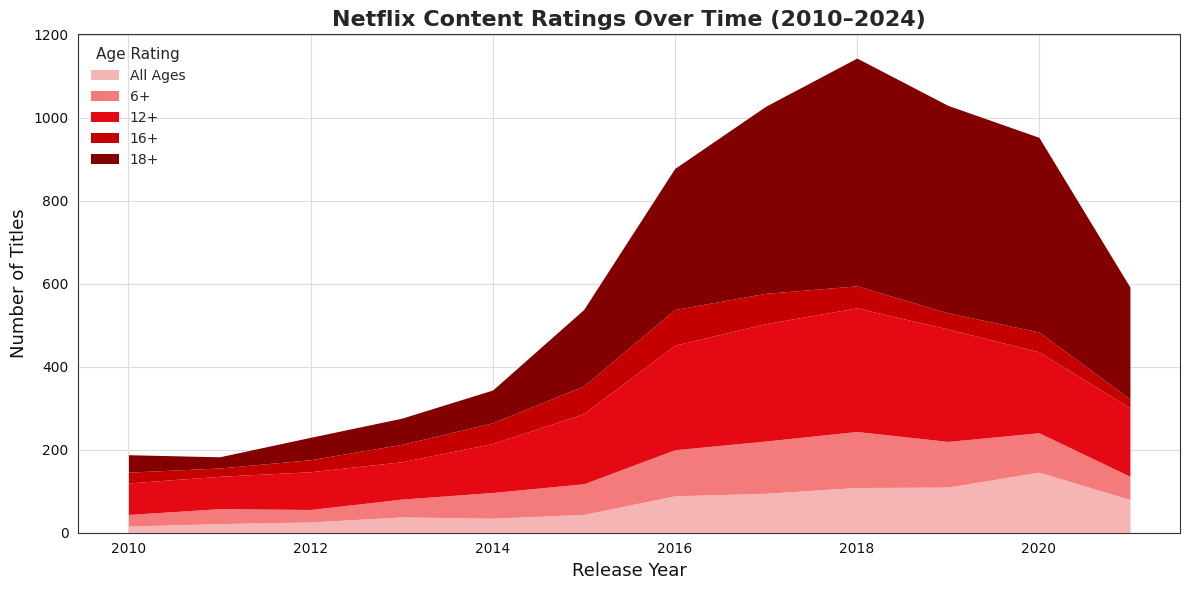

In [15]:
# 📈 Chart 1: Rating Evolution Over Time (Stacked Area Chart)
# ------------------------------------------------------------
# Visualizes how Netflix's catalog has shifted toward mature content.

# 📊 Group data: count titles per year × age category
rating_by_year = (
    df.groupby(['release_year', 'age_rating'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=age_order, fill_value=0)  # ensures color order matches
)

# 🎨 Plotting: stacked area chart
rating_by_year.plot.area(
    color=get_age_colors(),  # from your design loader
    linewidth=0
)

plt.title("Netflix Content Ratings Over Time (2010–2024)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend(title="Age Rating", loc="upper left")
plt.tight_layout()
plt.show()

## Graph2 (Sven) - Composition by Rating
Confirms the shift: mature content now dominates share.


Chart 2: Composition of Age Ratings by Year

From All Ages to 18+: How Netflix’s Library Aged

While raw title counts highlight growth, they don’t reveal how Netflix’s catalog composition evolved. This normalized stacked bar chart makes that shift visible: by treating each year as 100%, we can clearly see how the share of family content (All Ages, 6+) steadily declined — squeezed out by the rising share of mature-rated content (12+, 16+, 18+). Around 2016, the balance tips: 18+ titles become the dominant slice. By normalizing the data, we decouple volume from structure and reveal a deeper trend — Netflix didn’t just expand its library, it redefined its audience.

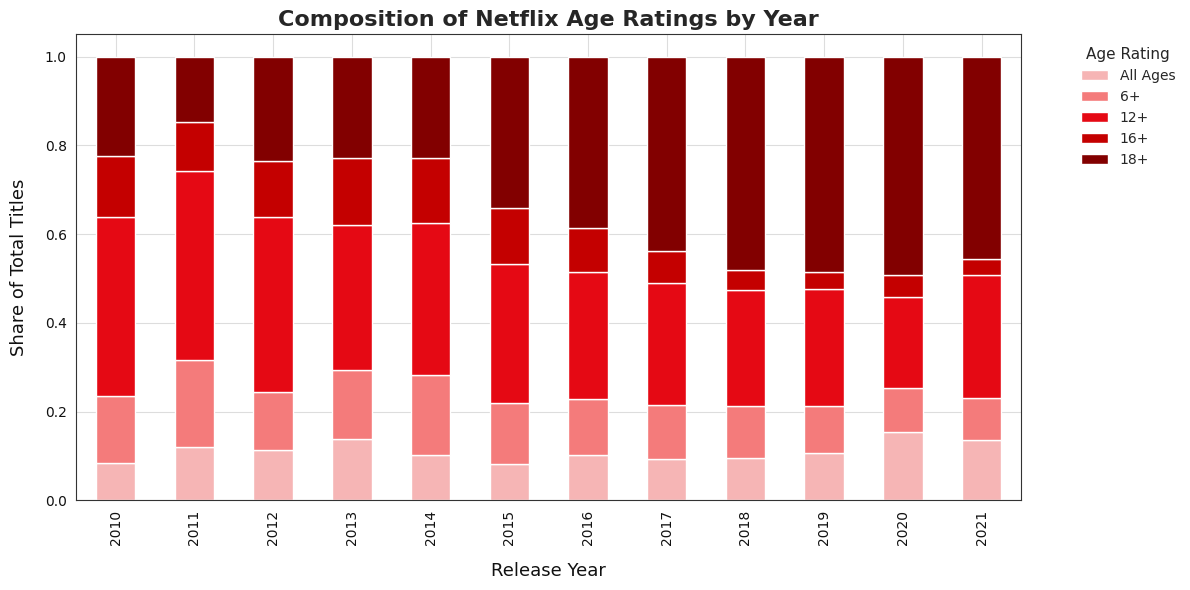

In [16]:
# 📊 Chart 2: Composition of Age Ratings Over Time (Normalized Stacked Bar)
# -------------------------------------------------------------------------
# Shows how the *proportion* of content in each age rating changed year by year.

# ✅ Assumes unified data + design loaders already ran

# 🧮 Group + Normalize
rating_by_year = (
    df.groupby(['release_year', 'age_rating'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=age_order, fill_value=0)
)

rating_by_year_norm = rating_by_year.div(rating_by_year.sum(axis=1), axis=0)

# 🎨 Plot
ax = rating_by_year_norm.plot(
    kind="bar",
    stacked=True,
    color=get_age_colors(),
)

# 🔧 Add spacing to axis labels
ax.set_xlabel("Release Year", labelpad=12)  # space between label and ticks
ax.set_ylabel("Share of Total Titles", labelpad=12)  # vertical axis

plt.title("Composition of Netflix Age Ratings by Year")
plt.legend(
    title="Age Rating",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

## Graph3 (Sven) Genre vs Rating
Reveals that Drama, Thriller, HOrror = mature, Kids, Family = G/PG

Chart 3: Genre vs. Age Rating (Heatmap)

Genres Grow Up Too: Mapping Maturity by Genre

Genres don’t just entertain — they signal intended audiences. These two heatmaps cross-reference genres with age ratings for both Movies and TV Shows, revealing clear maturity patterns. Drama, Thriller, and Horror are heavily weighted toward mature content (16+, 18+), while genres like Animation, Kids, and Family remain strongly aligned with family-friendly ratings (All Ages, 6+). By removing in-cell annotations and using color intensity alone, the heatmaps emphasize the structural divide without distraction. This visual reinforces the story’s core argument: Netflix’s shift toward mature content is not only temporal — it’s genre-driven, deliberate, and consistent across formats.

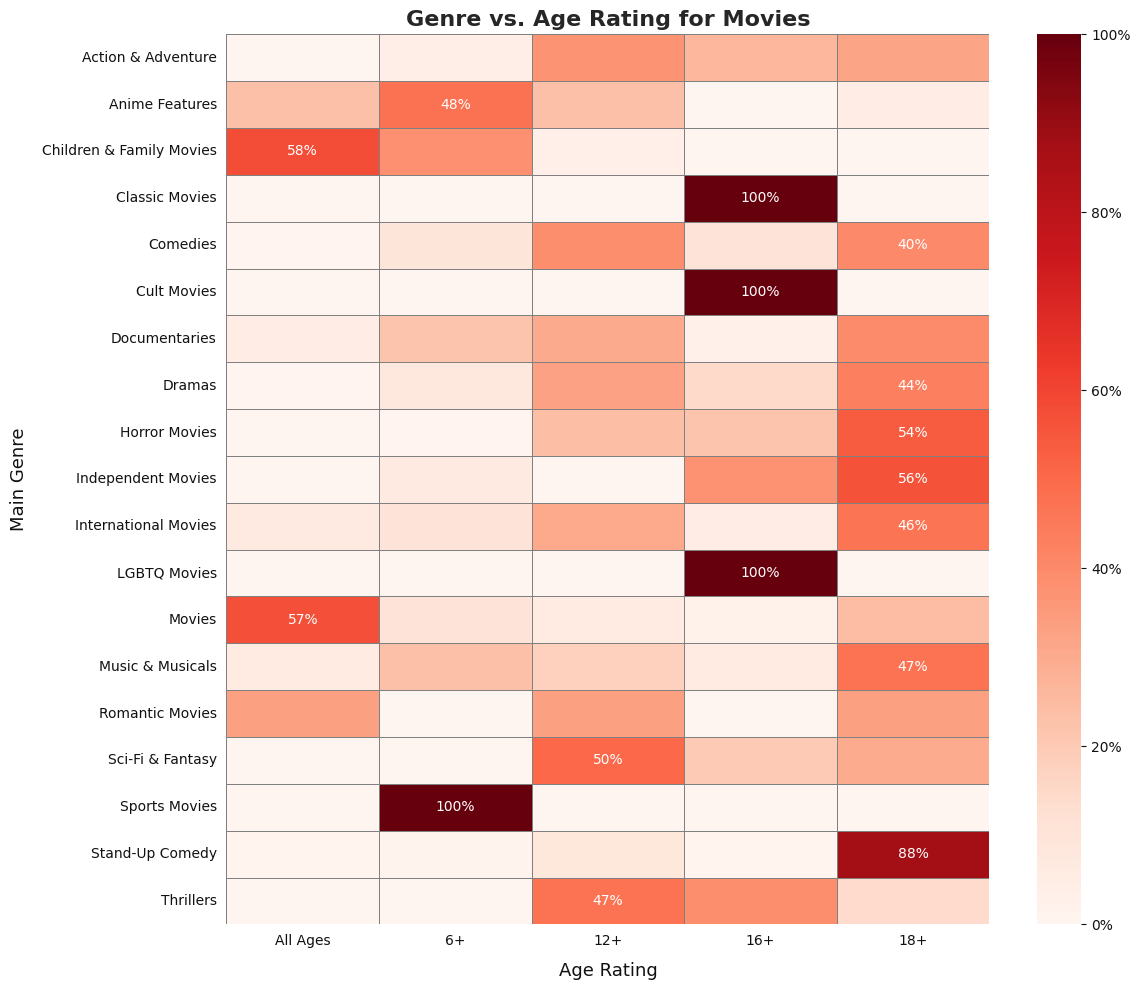

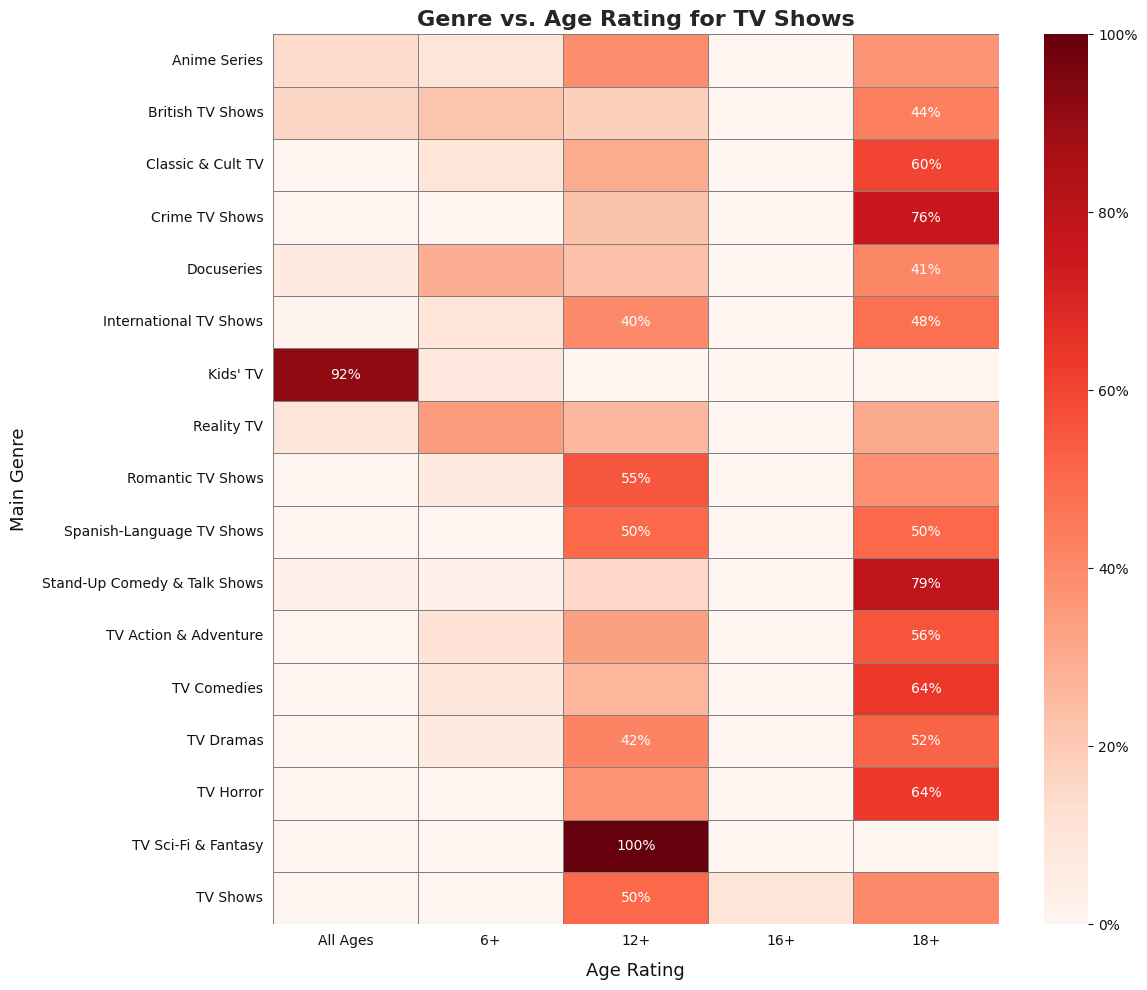

In [17]:
# 📊 Chart 3: Genre vs. Age Rating (Heatmap) — Split by Type
# -----------------------------------------------------------
# Assumes:
# - `df` loaded + preprocessed with your unified data loader
# - `age_order` and design styles (colors, fonts, etc.) are already set via design loader

import matplotlib.pyplot as plt
import seaborn as sns

# ✅ No need to set style/size again – handled in design cell

# 📊 Heatmap function: Genre × Age Rating, per content type
def plot_genre_rating_heatmap(content_type):
    # Filter by content type (Movie or TV Show)
    subset = df[df['type'] == content_type]

    # Crosstab: main genre × age rating (normalized by genre row)
    genre_rating_pct = pd.crosstab(
        subset['main_genre'],
        subset['age_rating'],
        normalize='index'
    ).reindex(columns=age_order, fill_value=0)

    # Show % label only if value > 40%
    annot_data = genre_rating_pct.map(
        lambda val: f"{val:.0%}" if val > 0.4 else ""
    )

    # 🔥 Plot heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        genre_rating_pct,
        cmap="Reds",
        annot=annot_data,
        fmt='',
        linewidths=0.5,
        linecolor='gray',
        vmin=0,
        vmax=1,
        cbar_kws={
            'format': '%.0f%%',
            'ticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        }
    )

    # Format colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # 🧾 Titles + labels
    plt.title(f"Genre vs. Age Rating for {content_type}s")
    plt.xlabel("Age Rating", labelpad=10)
    plt.ylabel("Main Genre", labelpad=10)
    plt.tight_layout()
    plt.show()

# 🔥 Plot for Movies
plot_genre_rating_heatmap("Movie")

# 📺 Plot for TV Shows
plot_genre_rating_heatmap("TV Show")

## Graph4 (Boris) - Top Countries by Mature Titles

Story Block: Chart 4 – Maturity by Country (Bubble Chart)

Mature by Market: How Countries Shape Netflix’s Shift to 18+

While age ratings and genres reveal how Netflix’s catalog matured structurally, this bubble chart shows where that shift is happening geographically. Each country’s position reflects both its catalog size and the share of mature content within it. The United States — Netflix’s largest market — not only dominates in volume, but also holds a mature-content share just above the global median. The United Kingdom follows with a higher proportion of mature titles, while countries like Japan and India remain below the maturity midpoint despite significant title counts.
This geographic lens reinforces the story so far: Netflix’s maturation is not uniform — it’s led by Western markets, and emerging regions may still reflect older, family-focused programming strategies.

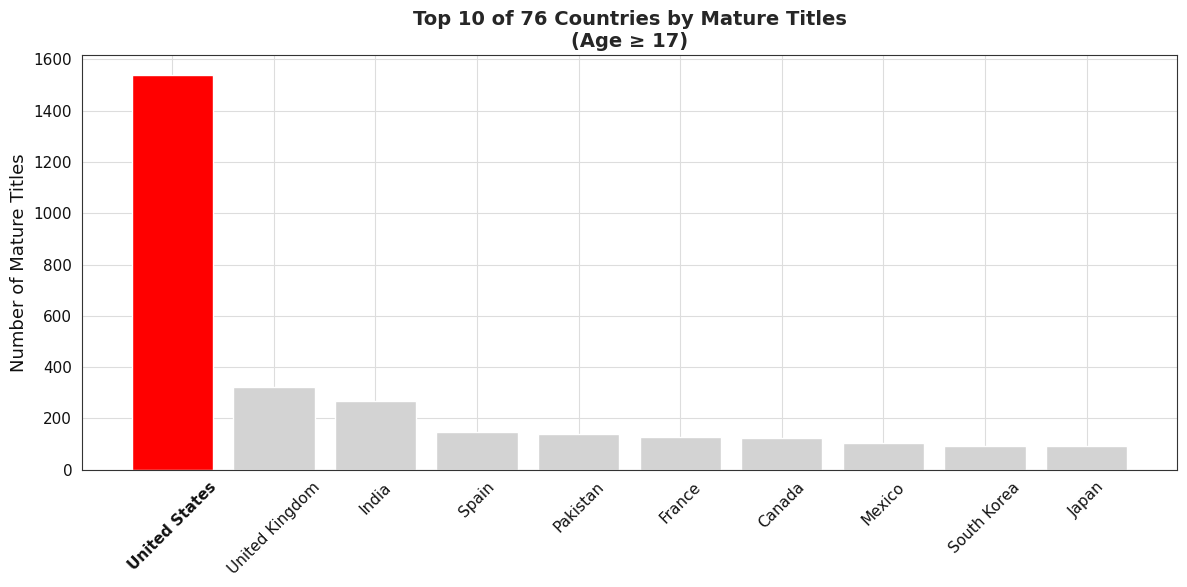

In [40]:
import matplotlib.pyplot as plt

# ---- Mature-Filter ----
AGE_FILTER = 17
TOP_N_COUNTRIES = 10

df_mature = df_netflix.query('rating_age >= @AGE_FILTER')

# ---- Länder zählen ----
country_counts = (
    df_mature['country_clean']
    .value_counts()
    .head(TOP_N_COUNTRIES)  # Top 10
)

# ---- Farben definieren ----
colors = [BAR_FORMATS['highlight']['color']] + [BAR_FORMATS['deemphasize']['color']] * (len(country_counts) - 1)

# ---- Plot ----
fig, ax = plt.subplots()
bars = ax.bar(country_counts.index, country_counts.values, color=colors)

# ---- Titel ----
total_n_countries = len(df_mature['country_clean'].unique())
ax.set_title(
    f"Top {TOP_N_COUNTRIES} of {total_n_countries} Countries by Mature Titles\n(Age ≥ {AGE_FILTER})"
)

ax.set_xlabel("")
ax.set_ylabel("Number of Mature Titles")
ax.tick_params(axis='x', rotation=45)

# ---- Top-Country Label fett machen ----
for tick_label in ax.get_xticklabels():
    if tick_label.get_text() == country_counts.index[0]:  # erstes Land
        tick_label.set_fontweight('bold')

plt.tight_layout()
plt.show()


Story Block: Chart 5 – Top Countries by Mature Titles (Bar Chart)

Who’s Producing the Most Mature Content? A Clear Winner Emerges

While maturity share shows how a country's catalog is structured, this bar chart ranks countries by the total number of mature titles (age ≥ 17). The result is striking: the United States dominates this space, producing more than four times as many mature titles as the next-highest country. Other top contributors include the United Kingdom, India, and France — but none come close to Hollywood’s output.
This reinforces a key insight: Netflix’s shift toward adult content is largely powered by U.S. production. Whether driven by audience demand, creative freedom, or platform strategy, American content sets the tone for what “mature” means on Netflix.

In [41]:
import plotly.express as px

# Datensatz filtern
min_age = 17
df_mature = df_netflix.query('rating_age >= @min_age')
df_mature_exp = df_mature.explode('genres_list')

# Nur gültige Einträge
df_mature_exp = df_mature_exp.dropna(subset=["country", "genres_list"])

# Top-Land bestimmen
country_counts = df_mature_exp['country'].value_counts()
top_country = country_counts.index[0]
total_titles = country_counts.sum()

# Anteil berechnen
country_percent = (country_counts / total_titles * 100).round(1)

# Optional: neues Label mit Anteil erstellen
df_mature_exp['country_label'] = df_mature_exp['country'].apply(
    lambda c: f"{c} ({country_percent[c]}%)" if c in country_percent else c
)

# Farbdict erstellen
color_map = {c: BAR_FORMATS['highlight']['color'] if c == top_country else BAR_FORMATS['deemphasize']['color']
             for c in df_mature_exp["country"].unique()}

fig = px.treemap(
    df_mature_exp,
    path=["country_label", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age > {min_age} years old)"
)

# Top-Country fett darstellen
fig.update_traces(
    texttemplate="%{label}",  # Label bleibt gleich
    selector=dict(type='treemap')
)

# Labels fett für das Top-Country
# Dazu kann man in df_mature_exp ein spezielles HTML-Tag verwenden
df_mature_exp['country_label_html'] = df_mature_exp['country_label'].apply(
    lambda x: f"<b>{x}</b>" if top_country in x else x
)

fig = px.treemap(
    df_mature_exp,
    path=["country_label_html", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age ≥ {min_age} years old)"
)

fig.update_traces(
    textinfo="label+value+percent parent",
)

fig.update_layout(
    title=dict(
        # Bolt title geht nur via HTML-Tag fürs px, da rcparam nicht direkt supported
        text=f"<b>Mature Titles Per Country (min. age ≥ {min_age} years old)</b>",
        font=dict(size=16, family="DejaVu Sans")
    )
)

fig.show()


Now that we've identified the United States as the leading producer of mature content on Netflix, it’s worth asking: what does 'mature' really mean in this context? Is it truly about explicit content, or something else entirely?

### Popcorn or Popporn?
If you search the Netflix database for the keyword “sex,” a total of 18 titles appear, all of which are classified under harmless genres such as comedies, dramas, reality TV, etc. Interested readers should note at this point that there is a significant difference between “mature content” and “adult content.” The latter category does not seem to fit with Netflix's strategy and, interestingly, is not offered at all.

### On the trail of explicit language, sex, and dark humor
Let's search for well-known titles that may be US mature content but are rated FSK>18.
The search for often ambiguous animated films such as “South Park,” but also "Deadpool" or “The Wolf of Wall Street” are not even included in the Netflix database.

A quick search for suspicious movie titles then gives us the following hits:
| Title                         | US-Rating (MAA)                  | FSK-Rating |
|-------------------------------|----------------------------------|------------|
| Zack and Miri Make a Porno    | R - Restricted Mature/Adult      | FSK-16     |
| American Pie 9: Girls' Rules  | R - Restricted Mature/Adult      | FSK-15     |
| Superbad                      | R - Restricted Mature/Adult      | FSK-16     |
| ...                           | ...                              | ...        |

(R* = ages 17 and up, only permitted with parents)


This shows that...  
a) on the one hand, Titles in the Netflix database are classified using a unified, predominantly US-oriented rating scheme rather than the original regional rating systems.  
b) Within a unified, US-oriented rating framework, US comedy titles are classified as non-youth-rated significantly more often than comparable titles from other countries. This suggests that either US comedies more frequently contain elements that trigger restrictive classifications, or that the rating system is particularly sensitive to stylistic features prevalent in US comedy.


This pattern may contribute to the perception of a paradox between restrictive classification practices and the prevalence of mature-themed comedy in US productions: **hypocritical prudery is refuted by reality.**. However, this interpretation goes beyond what can be directly inferred from rating data alone.


In [21]:
candidate_titles = [ #friendly provided by ChatGPT for this purpose
    "superbad",
    "40-year-old virgin",
    "40 year old virgin",
    "american pie",
    "wedding crashers",
    "knocked up",
    "hall pass",
    "forgetting sarah marshall",
    "zack and miri",
    "american wedding",
    "american pie 2"
]

pattern = "|".join(candidate_titles)

df_candidates = df_netflix[
    df_netflix['title']
    .str.lower()
    .str.contains(pattern, regex=True, na=False)
]
df_candidates[['title','rating','country']]

,title,rating,country
988,Zack and Miri Make a Porno,R,United States
1612,American Pie 9: Girls' Rules,R,United States
5974,Superbad,R,United States


To explore this further, we searched for a curated list of U.S. comedies with suggestive or sexual themes — all of which are marked as “R” (17+) in the dataset. These include titles like Superbad, American Pie, and Zack and Miri Make a Porno.
While all are technically “mature,” they belong to mainstream comedic genres and would likely receive lower ratings in other regions. This supports the idea that Netflix’s “mature content” is partially shaped by stylistic conventions and national rating policies, especially in the U.S.

Prozentuale Mature-Titel nach Land und Genre:


/tmp/ipykernel_45055/1298536843.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_45055/1298536843.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_45055/1298536843.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `incl

,Dramas,Independent Movies,Comedies
Other countries,46.3,63.1,35.2
United States,58.6,81.9,39.1


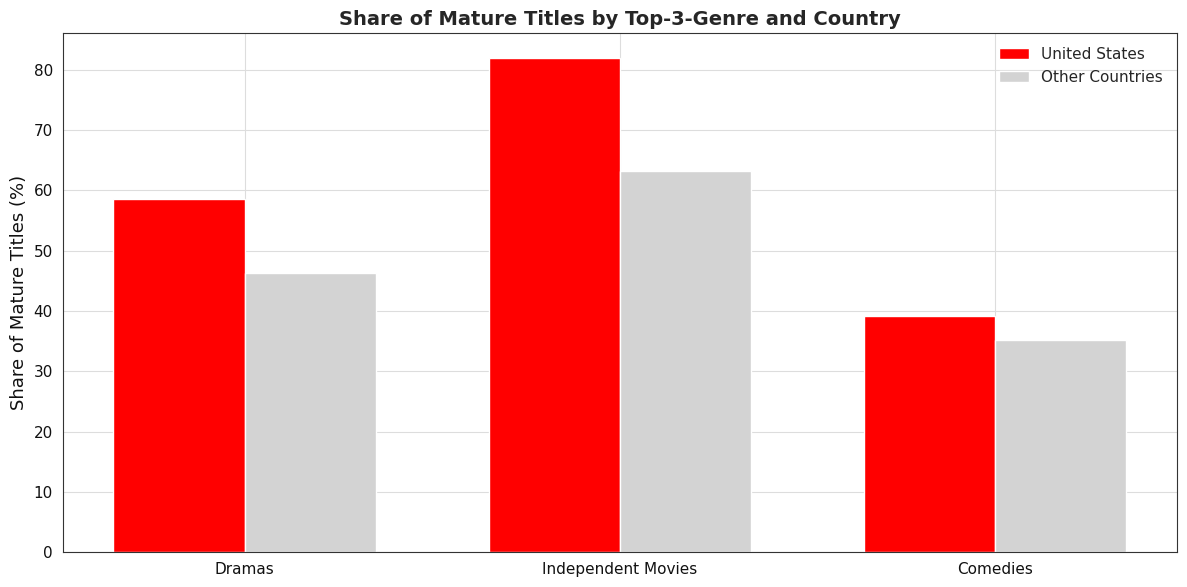

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Genres of interest
genres_of_interest = ['Dramas', 'Independent Movies', 'Comedies']

# Flags für jedes Genre
for genre in genres_of_interest:
    df_netflix[genre] = df_netflix['genres_list'].apply(lambda g: genre in g if isinstance(g, list) else False)

df_netflix['is_mature'] = df_netflix['rating_age'] >= 17
df_netflix['is_us'] = df_netflix['country_clean'] == 'United States'

# Aggregation: Anteil Mature pro Land und Genre
summary = {}
for genre in genres_of_interest:
    summary[genre] = df_netflix.groupby('is_us').apply(
        lambda x: (x[genre] & x['is_mature']).sum() / x[genre].sum() if x[genre].sum() > 0 else 0
    )

summary = pd.DataFrame(summary)
summary.index = ['Other countries', 'United States']
summary_percent = (summary * 100).round(1)

print("Prozentuale Mature-Titel nach Land und Genre:")
display(summary_percent)

# Plot: je Genre eine Gruppe, zwei Bars pro Genre
n_genres = len(genres_of_interest)
x = np.arange(n_genres)
width = 0.35

#fig, ax = plt.subplots(figsize=(8,5))
fig, ax = plt.subplots()

# Farben setzen
ax.bar(x - width/2, summary_percent.loc['United States'], width, label='United States', color=BAR_FORMATS['highlight']['color'])
ax.bar(x + width/2, summary_percent.loc['Other countries'], width, label='Other Countries', color=BAR_FORMATS['deemphasize']['color'])

ax.set_ylabel('Share of Mature Titles (%)')
ax.set_title('Share of Mature Titles by Top-3-Genre and Country')
ax.set_xticks(x)
ax.set_xticklabels(genres_of_interest)
ax.legend()
plt.tight_layout()
plt.show()


Genre-Based Maturity Bias

Genre Matters: The U.S. Labels More Content ‘Mature’ — Even in Drama and Comedy

To test whether U.S. titles are consistently rated as more mature than comparable international content, we examined three genres that frequently appear in Netflix’s mature catalog: Dramas, Independent Movies, and Comedies. The chart compares the share of mature titles (age ≥17) in each genre between the U.S. and all other countries combined.

The differences are clear. In every genre, the U.S. labels a larger share of content as mature. This gap is especially pronounced in Independent Movies (82% vs. 63%) and Dramas (59% vs. 46%). Even Comedies — often associated with lighter themes — are more likely to be rated R in the U.S. than abroad.

These findings reinforce the hypothesis that rating practices in the U.S. skew more conservative, especially in how language, sexuality, and tone are treated in otherwise mainstream genres.

## Graph6 - Genre Popularity by Country
What genres are dominant in U.S., India, UK, Japan?

If you read these genre fingerprints like a heatmap, one thing becomes clear: Netflix is global — but each country has its own catalog signature.  
The **U.S.** looks like the baseline market: broad and balanced, with no extreme peaks — just slightly more documentaries, family titles, and stand-up.  
**India** stands out much more: it’s heavily driven by movies and drama, and a large share appears under the **‘International Movies’** label.  
The **UK** has a very distinct identity through formats: **British TV** plus a strong focus on documentaries and docuseries.  
And **Japan** is the most distinctive profile: **anime and serialized content** dominate, while classic drama and comedy tags show up far less often.

**Netflix takeaway:** Netflix isn’t one uniform global catalog — it’s a mix of **local strengths** and **label/taxonomy effects**.  
Some differences are cultural (e.g., Japan/anime), while others are driven by categorization (e.g., ‘International’ vs. the U.S.).  
Overall, the chart shows: Netflix scales globally — but **local identity remains the key lever** that makes each market’s offering distinct.”


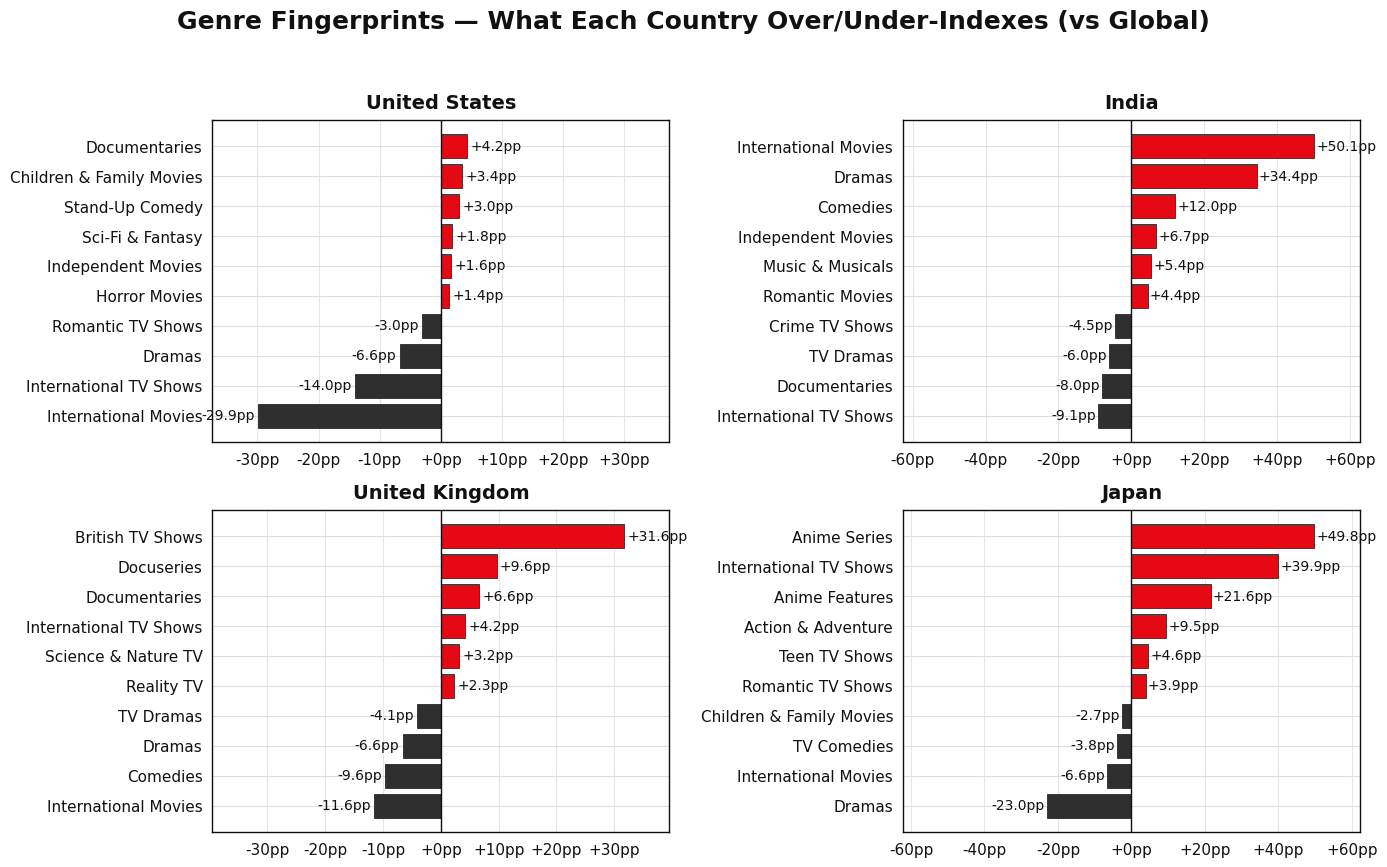

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# -----------------------------
# Config
# -----------------------------
CSV_CANDIDATES = ["../data/netflix1.csv", "netflix1.csv", "/mnt/data/netflix1.csv"]
COUNTRIES = ["United States", "India", "United Kingdom", "Japan"]

TOP_POS = 6   # top over-indexed genres per country
TOP_NEG = 4   # top under-indexed genres per country
MIN_COUNT = 5 # optional noise filter: at least this many titles per country+genre

NETFLIX_RED = "#E50914"
DARK = "#111111"
DARK_GREY = "#2F2F2F"
LIGHT_GREY = "#E6E6E6"

# -----------------------------
# Load data
# -----------------------------
csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("Could not find netflix1.csv (tried ../data/, current folder, /mnt/data/).")

df = pd.read_csv(csv_path)

# Use stable ID if present
id_col = "show_id" if "show_id" in df.columns else None
if id_col is None:
    df = df.reset_index().rename(columns={"index": "title_id"})
    id_col = "title_id"

required = {"country", "listed_in"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Found: {list(df.columns)}")

def split_list(val):
    if pd.isna(val):
        return []
    return [x.strip() for x in str(val).split(",") if x.strip()]

# Deduplicate titles
base = df[[id_col, "country", "listed_in"]].dropna(subset=["listed_in"]).drop_duplicates(subset=[id_col]).copy()
base["country_list"] = base["country"].apply(split_list)
base["genre_set"] = base["listed_in"].apply(lambda x: set(split_list(x)))  # avoid double-count per title

# -----------------------------
# Build long table: (title, country, genre) unique
# -----------------------------
rows = []
for _, r in base.iterrows():
    countries = r["country_list"]
    genres = r["genre_set"]
    if not countries or not genres:
        continue
    for c in countries:
        for g in genres:
            rows.append((r[id_col], c, g))

long = pd.DataFrame(rows, columns=[id_col, "country", "genre"])
long = long.drop_duplicates(subset=[id_col, "country", "genre"])

# Keep only the 4 target countries
long4 = long[long["country"].isin(COUNTRIES)].copy()

# -----------------------------
# Compute global genre shares
# (each title contributes once to a genre)
# -----------------------------
global_total_titles = base[id_col].nunique()

g_rows = []
for _, r in base.iterrows():
    for g in r["genre_set"]:
        g_rows.append((r[id_col], g))
g_long = pd.DataFrame(g_rows, columns=[id_col, "genre"]).drop_duplicates(subset=[id_col, "genre"])

global_genre_counts = g_long.groupby("genre")[id_col].nunique()
global_share = global_genre_counts / global_total_titles

# -----------------------------
# Compute country genre shares
# -----------------------------
country_total_titles = long4.groupby("country")[id_col].nunique().reindex(COUNTRIES)

country_genre_counts = (
    long4.groupby(["country", "genre"])[id_col]
    .nunique()
    .unstack(fill_value=0)
    .reindex(index=COUNTRIES, fill_value=0)
)

country_share = country_genre_counts.div(country_total_titles, axis=0)

# Align columns for delta calc
all_genres = sorted(set(country_share.columns).union(set(global_share.index)))
country_share = country_share.reindex(columns=all_genres, fill_value=0.0)
country_genre_counts = country_genre_counts.reindex(columns=all_genres, fill_value=0)
global_share = global_share.reindex(all_genres).fillna(0.0)

delta_pp = (country_share - global_share) * 100.0  # percentage points

# -----------------------------
# Select top over/under per country (with optional MIN_COUNT filter)
# -----------------------------
selection = {}
for c in COUNTRIES:
    counts = country_genre_counts.loc[c]
    eligible = counts[counts >= MIN_COUNT].index
    s = delta_pp.loc[c, eligible].dropna().sort_values(ascending=False)

    # fallback if too strict
    if len(s) < (TOP_POS + TOP_NEG):
        eligible = counts[counts >= 1].index
        s = delta_pp.loc[c, eligible].dropna().sort_values(ascending=False)

    sel = pd.concat([s.head(TOP_POS), s.tail(TOP_NEG)])
    selection[c] = sel.sort_values()  # barh: bottom->top

# -----------------------------
# Plot: 2x2 Genre Fingerprints
# -----------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
})

fig, axes = plt.subplots(2, 2, figsize=(14, 9), facecolor="white")
axes = axes.flatten()

def style_ax(ax):
    ax.set_facecolor("white")
    for sp in ax.spines.values():
        sp.set_color(DARK)
        sp.set_linewidth(1.0)
    ax.grid(axis="x", color=LIGHT_GREY, linewidth=0.8)
    ax.set_axisbelow(True)
    ax.tick_params(colors=DARK)

for ax, c in zip(axes, COUNTRIES):
    style_ax(ax)
    s = selection[c]  # index=genre, values=delta_pp
    y = np.arange(len(s))

    colors = [NETFLIX_RED if v > 0 else DARK_GREY for v in s.values]
    ax.barh(y, s.values, color=colors, edgecolor=DARK, linewidth=0.5)

    ax.axvline(0, color=DARK, linewidth=1.0)
    ax.set_yticks(y)
    ax.set_yticklabels(s.index)

    # Symmetric x-limits per panel
    lim = max(10, float(np.nanmax(np.abs(s.values))) * 1.25)
    ax.set_xlim(-lim, lim)

    # Tick labels as "pp"
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v:+.0f}pp"))

    # Value labels
    for yi, v in zip(y, s.values):
        ax.text(v + (0.6 if v >= 0 else -0.6), yi, f"{v:+.1f}pp",
                va="center", ha="left" if v >= 0 else "right",
                fontsize=10, color=DARK)

    ax.set_title(c, color=DARK, pad=8)

fig.suptitle("Genre Fingerprints — What Each Country Over/Under-Indexes (vs Global)",
             fontsize=18, fontweight="bold", color=DARK, y=0.98)

plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()

# Optional: save
# fig.savefig("netflix_genre_fingerprints_2x2.png", dpi=300, bbox_inches="tight")


## TODO: Conclusion
a. Recap key Inisghts. Do not introduce new data - just synthesize
    
Zwischen 2010 und 2024 hat sich das Netflix-Angebot nicht nur mengenmäßig erweitert, sondern auch inhaltlich verändert. Die folgende Grafik zeigt die Entwicklung der Veröffentlichungen nach Altersfreigabe über die Jahre.
Bis etwa 2015 war die Verteilung relativ ausgewogen. Danach jedoch nimmt die Anzahl an Inhalten mit der Altersfreigabe TV-MA und R deutlich zu — parallel zur starken Zunahme an Eigenproduktionen.
Spätestens ab 2020 dominiert TV-MA das Angebot, während familienfreundliche Titel zahlenmäßig stagnieren.
Dieser Wandel ist Ausdruck einer gezielten Strategie: Netflix hat sich mit seinem Publikum weiterentwickelt. Der Chart legt damit das zeitliche Fundament für die folgenden Analysen zu Genre, Ländern und Content-Struktur.

Wrapping Up Your Data Story

A Global Platform — but Local Fingerprints

Over the last decade, Netflix has matured — not just in volume, but in tone, genre, and structure. While age ratings and content strategies now skew heavily toward mature themes, this final chart reminds us that Netflix is not a monolith. Each major market brings its own genre fingerprint.
The U.S. overrepresents Documentaries and Stand-Up Comedy. India leans heavily into International and Romantic Movies. Japan dominates in Anime, and the U.K. stands out with British TV and Docuseries.
These local over-indexes show that maturity is not just about age ratings, but about cultural nuance. Netflix’s evolution is global in scale — but its strategy is shaped country by country, genre by genre.

With that, the picture is complete: Netflix’s catalog isn’t just more mature — it’s more tailored. A global service with regional identities, blending mass appeal with market precision.